Submitted by:
Maham Waseem (27257)

Hierarchical Clustering

Importing the required dependencies

In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency
from sklearn.feature_selection import f_classif
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

Creating Functions
</br>
1-LoadData </br>
2-CleanFun </br>
3-KYFS </br>
4-FTRsclt </br>
5-PCAViz </br>
6-ClusterFun </br>
7-VizFun </br>

1. LoadData

In [2]:
import chardet
import pandas as pd

def LoadData(Loc):
    # Read the raw data to detect encoding
    rawdata = open(Loc, 'rb').read()
    result = chardet.detect(rawdata)

    # Read the CSV file using the detected encoding
    data = pd.read_csv(Loc, encoding=result['encoding'])

    return data



Noise Removal Function

In [3]:
import pandas as pd

def remove_outliers_iqr(data):
    # Copy the data to avoid modifying the original data
    clean_data = data.copy()

    # Loop through each column in the data
    for column in clean_data.select_dtypes(include=['float64', 'int64']).columns:  # Only numeric columns
        Q1 = clean_data[column].quantile(0.25)  # 1st quartile
        Q3 = clean_data[column].quantile(0.75)  # 3rd quartile
        IQR = Q3 - Q1  # Interquartile Range

        # Calculate the lower and upper bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filter the data to remove outliers
        clean_data = clean_data[(clean_data[column] >= lower_bound) & (clean_data[column] <= upper_bound)]

    return clean_data


Encoding function

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def encode_data(dataframe):
    # Ensure the dataframe is a pandas DataFrame
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input should be a pandas DataFrame.")

    # Initialize the LabelEncoder
    label_encoder = LabelEncoder()

    # Identify categorical and integer columns
    categorical_cols = dataframe.select_dtypes(include=['object']).columns
    integer_cols = dataframe.select_dtypes(include=['int64', 'float64']).columns

    # Encode categorical columns using Label Encoding
    for col in categorical_cols:
        dataframe[col] = label_encoder.fit_transform(dataframe[col].astype(str))

    # Integer columns remain unchanged, no scaling applied

    return dataframe

2. CleanFun

In [5]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

def CleanData(df):
    """
    Generalized function to clean a dataset with categorical, integer, binary, continuous, and boolean data types.
    - Automatically handles missing values, encodes categorical data, and scales continuous and integer data.

    Parameters:
    - df: The input DataFrame.

    Returns:
    - df_cleaned: The cleaned and transformed DataFrame.
    """
    # Step 1: Handle special missing value representations ("?" in this dataset)
    df.replace('?', np.nan, inplace=True)

    # Step 2: Detect column types
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    integer_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()

    # Detect binary columns (those with exactly 2 unique values)
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]

    # Detect boolean columns
    boolean_cols = df.select_dtypes(include=['bool']).columns.tolist()

    # Convert boolean columns to integers (0 and 1)
    df[boolean_cols] = df[boolean_cols].astype(int)

    # Remove binary and boolean columns from integer cols since they are handled separately
    integer_cols = [col for col in integer_cols if col not in binary_cols + boolean_cols]

    # Step 3: Handle missing values
    # Fill missing continuous values with the mean
    if continuous_cols:
        imputer_cont = SimpleImputer(strategy='mean')
        df[continuous_cols] = imputer_cont.fit_transform(df[continuous_cols])

    # Fill missing integer values with the median
    if integer_cols:
        imputer_int = SimpleImputer(strategy='median')
        df[integer_cols] = imputer_int.fit_transform(df[integer_cols])

    # Fill missing categorical values with the most frequent value (mode)
    if categorical_cols:
        imputer_cat = SimpleImputer(strategy='most_frequent')
        df[categorical_cols] = imputer_cat.fit_transform(df[categorical_cols])

    # Fill missing binary values with the mode
    if binary_cols:
        imputer_bin = SimpleImputer(strategy='most_frequent')
        df[binary_cols] = imputer_bin.fit_transform(df[binary_cols])

    # Step 4: Encode categorical variables (One-hot encoding)
    df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

    # Step 5: Scale continuous and integer variables
    scaler = StandardScaler()
    if continuous_cols:
        df_encoded[continuous_cols] = scaler.fit_transform(df_encoded[continuous_cols])
    if integer_cols:
        df_encoded[integer_cols] = scaler.fit_transform(df_encoded[integer_cols])

    return df_encoded



In [6]:

def list_columns_with_missing_values(df):
    result=df.isnull().sum(0)
    return result


def drop_null(df): #This function will clean the dataset by dropping null values.
    df.dropna(inplace=True)
    return(df)


def fill_null_mean(df):

    df_float = df.select_dtypes(include='float64').columns.tolist()
    # Make a copy of float columns
    X = df[df_float].copy()

    # Calculate means of each column
    means = X.mean()

    # Fill missing values with mean values
    X.fillna(value=means, inplace=True)

    # Assign the filled float columns back to the original DataFrame
    df[df_float] = X

    return df



def CleanFun(data): #This function will clean the dataset.

    print("Number of missing values in your data set:",list_columns_with_missing_values(data))

    print("Number of duplicate rows in your data set:",data.duplicated().sum())
    print("All the missing values have been filled wtih mean values")
    print("All the duplicate rows have been deleted from data set")


    data.drop_duplicates(inplace=True)
    data = fill_null_mean(data)
    return(data)




3. KYFS

In [7]:
def KYFS(df):

    desc = pd.DataFrame(index = list(df))
    desc['type'] = df.dtypes
    desc['count'] = df.count()
    desc['nunique'] = df.nunique()
    desc['%unique'] = desc['nunique'] / len(df) * 100
    desc['null'] = df.isnull().sum()
    desc['%null'] = desc['null'] / len(df) * 100
    desc['min'] = df.min()
    desc['max'] = df.max()
    return desc;

In [8]:
def ViewColumnTypes(df):
    """
    View which columns are categorical, continuous, integer, and binary.

    Parameters:
    - df: The input DataFrame.

    Returns:
    - A dictionary containing column names categorized by type.
    """
    # Step 1: Get columns by data types
    categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
    continuous_cols = df.select_dtypes(include=['float64', 'float32']).columns.tolist()
    integer_cols = df.select_dtypes(include=['int64', 'int32']).columns.tolist()

    # Step 2: Identify binary columns (those with exactly two unique values)
    binary_cols = [col for col in df.columns if df[col].nunique() == 2]

    # Print the results
    print(f"Categorical Columns: {categorical_cols}")
    print(f"Continuous Columns: {continuous_cols}")
    print(f"Integer Columns: {integer_cols}")
    print(f"Binary Columns: {binary_cols}")

    # Return the results in a dictionary (for potential future use)
    return {
        "categorical_cols": categorical_cols,
        "continuous_cols": continuous_cols,
        "integer_cols": integer_cols,
        "binary_cols": binary_cols
    }


4. FTRsclt

In [9]:
def FtrSlct(df, hist_color='MAROON', boxplot_color='MAROON'):
    # Separating numerical and categorical features
    numeric_features = df.select_dtypes(include=['float64','int64','int32'])
    categorical_features = df.select_dtypes(include=['object', 'int64'])

    # Summary statistics
    summary_stats = numeric_features.describe().style.set_properties(**{'color': 'maroon', 'text-align': 'center', 'font-weight': 'bold'})
    print("\n\033[1m\033[91mSummary Statistics:\033[0m")
    display(summary_stats)


    num_cols = len(numeric_features.columns)
    num_rows = (num_cols - 1) // 3 + 1  # Calculate number of rows needed

    # Histograms and Box plots
    fig, axes = plt.subplots(nrows=num_rows*2, ncols=3, figsize=(16, 5*num_rows))

    for i, column in enumerate(numeric_features.columns):
        row = i // 3
        col = i % 3

        sns.histplot(df[column], bins=20, kde=True, color=hist_color, ax=axes[row*2, col])
        axes[row*2, col].set_title(f'Histogram of {column}')
        axes[row*2, col].set_xlabel(column)
        axes[row*2, col].set_ylabel('Frequency')

        sns.boxplot(data=df, y=column, color=boxplot_color, ax=axes[row*2+1, col])
        axes[row*2+1, col].set_title(f'Boxplot of {column}')
        axes[row*2+1, col].set_ylabel(column)

    plt.tight_layout()
    plt.show()

    # Correlation matrix
    # Calculate correlation matrix
    correlation_matrix = numeric_features.corr()

    # Correlation matrix
    plt.figure(figsize=(30, 30))
    sns.heatmap(correlation_matrix, cmap="coolwarm", annot=True, fmt=".2f", linewidths=1)
    plt.title('Correlation Heatmap of 30 Variables')
    plt.xlabel('Variables')
    plt.ylabel('Variables')
    plt.show()



Normalization

In [10]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Function to normalize data and show new ranges
def normalize_data(dataframe):
    # Ensure the dataframe is a pandas DataFrame
    if not isinstance(dataframe, pd.DataFrame):
        raise ValueError("Input should be a pandas DataFrame.")

    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()

    # Apply Min-Max scaling to all columns (assuming numerical data)
    normalized_data = scaler.fit_transform(dataframe)

    # Create a DataFrame with normalized values
    normalized_df = pd.DataFrame(normalized_data, columns=dataframe.columns)

    # Display the new ranges of individual features
    new_ranges = normalized_df.min(), normalized_df.max()
    print("New Ranges of the Features:")
    for feature, (min_val, max_val) in zip(normalized_df.columns, zip(new_ranges[0], new_ranges[1])):
        print(f"{feature}: Min = {min_val}, Max = {max_val}")

    return normalized_df


In [12]:
import numpy as np
from sklearn.neighbors import KernelDensity

def kde_bandwidth_selection(X, bandwidths=np.linspace(0.1, 5.0, 50)):
    """
    Estimate bandwidth using Kernel Density Estimation (KDE) for local density estimation.

    Parameters:
        X (numpy array): The input data (2D array, n_samples x n_features).
        bandwidths (numpy array): Array of candidate bandwidth values to test.

    Returns:
        float: The optimal bandwidth that maximizes the likelihood.
    """
    best_bandwidth = None
    best_score = -np.inf

    # Iterate over different bandwidth values
    for bandwidth in bandwidths:
        kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth)
        kde.fit(X)

        # Compute the log-likelihood of the data
        score = kde.score(X)

        # Track the best bandwidth
        if score > best_score:
            best_score = score
            best_bandwidth = bandwidth

    print(f"Optimal Bandwidth (KDE): {best_bandwidth}")
    return best_bandwidth

# Example usage
# X is your data (replace with actual dataset)

In [13]:
import numpy as np
from sklearn.neighbors import NearestNeighbors

def rule_of_thumb_bandwidth(X, k=5):
    """
    Estimate bandwidth using the Rule of Thumb (Median Distance to k-th Nearest Neighbor).

    Parameters:
        X (numpy array): The input data (2D array, n_samples x n_features).
        k (int): The number of nearest neighbors to consider (default is 5).

    Returns:
        float: The estimated bandwidth.
    """
    # Fit nearest neighbors model to the data
    nbrs = NearestNeighbors(n_neighbors=k).fit(X)

    # Compute the distances to the k-th nearest neighbor
    distances, _ = nbrs.kneighbors(X)

    # Take the k-th nearest neighbor distance for each point
    kth_distances = distances[:, -1]

    # Return the median of these distances as the bandwidth
    bandwidth = np.median(kth_distances)

    print(f"Estimated Bandwidth (Rule of Thumb): {bandwidth}")
    return bandwidth

# Example usage
# X is your data (replace with actual dataset)

Grid Search with TSNE

In [14]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def tsne_perform_clustering_and_plot(data):
    # Define parameter grid for MeanShift
    bandwidth_values = np.linspace(0.2,1,3)  # Example range for `bandwidth` (adjust as needed)

    # Prepare a list to store results
    results_meanshift = []

    # MeanShift Grid Search
    for bandwidth in bandwidth_values:
        meanshift = MeanShift(bandwidth=bandwidth)
        meanshift_labels = meanshift.fit_predict(data)
        n_clusters_meanshift = len(set(meanshift_labels)) - (1 if -1 in meanshift_labels else 0)
        noise_points_meanshift = np.sum(meanshift_labels == -1)
        results_meanshift.append([bandwidth, n_clusters_meanshift, noise_points_meanshift])

    # Convert results to DataFrame
    df_meanshift = pd.DataFrame(results_meanshift, columns=['bandwidth', 'n_clusters', 'noise_points'])

    # Select top models for visualization
    df_meanshift_sorted = df_meanshift.sort_values(by=['n_clusters', 'noise_points'], ascending=[False, True]).head(3)

    best_meanshift_models = []

    # Instantiate best MeanShift models
    for i in range(3):
        best_meanshift = MeanShift(bandwidth=df_meanshift_sorted.iloc[i]['bandwidth'])
        best_meanshift_models.append(best_meanshift)

    # Reduce data to 2D for visualization
    tsne = TSNE(n_components=2, random_state=42)
    data_tsne = tsne.fit_transform(data)

    # Plot results
    plt.figure(figsize=(15, 12))
    plt.suptitle("TSNE Plot with MeanShift Clustering", fontsize=16)  # Main heading for the entire plot

    # MeanShift Visualization
    for i, meanshift_model in enumerate(best_meanshift_models):
        meanshift_labels = meanshift_model.fit_predict(data)
        n_clusters_meanshift = len(set(meanshift_labels)) - (1 if -1 in meanshift_labels else 0)
        noise_points_meanshift = np.sum(meanshift_labels == -1)

        plt.subplot(3, 2, i * 2 + 1)
        plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=meanshift_labels, cmap='viridis')
        plt.title(f'MeanShift (bandwidth={meanshift_model.bandwidth}, clusters={n_clusters_meanshift}, noise={noise_points_meanshift})')
        plt.colorbar()

    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.show()


PCA Visualization

In [15]:
import numpy as np
import pandas as pd
from sklearn.cluster import MeanShift
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

def perform_clustering_and_plot(data, meanshift_params):
    # Unpack the MeanShift parameters
    bandwidth = meanshift_params

    # MeanShift Clustering
    meanshift = MeanShift(bandwidth=bandwidth)
    meanshift_labels = meanshift.fit_predict(data)
    n_clusters_meanshift = len(set(meanshift_labels))
    noise_points_meanshift = np.sum(meanshift_labels == -1)  # There is no -1 for noise in MeanShift, just count unique clusters

    # Reduce data to 2D for visualization using PCA
    pca = PCA(n_components=2)
    data_pca = pca.fit_transform(data)

    # Plot results
    plt.figure(figsize=(10, 8))

    # MeanShift Visualization
    plt.scatter(data_pca[:, 0], data_pca[:, 1], c=meanshift_labels, cmap='viridis')
    plt.title(f'MeanShift (bandwidth={bandwidth}, clusters={n_clusters_meanshift}, noise={noise_points_meanshift})')
    plt.colorbar()

    # Add a main title for the entire plot
    plt.suptitle('MeanShift Clustering with PCA', fontsize=16)

    plt.tight_layout()
    plt.show()



In [ ]:
#Cluster Visualization in High Dimensionality to check all the features working in every single clusters

In [ ]:
#Heatmap Function

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.preprocessing import MinMaxScaler

def HeatmapFeatureMeansWithClustering(df, bandwidth=2.0, show_meanshift=True):
    """
    Plot side-by-side heatmaps showing the normalized mean values of original features
    for each cluster using MeanShift clustering method after Min-Max scaling.

    Parameters:
    - df: DataFrame with original features.
    - bandwidth: The bandwidth parameter for MeanShift (default is 2.0).
    - show_meanshift: Boolean flag to show MeanShift clustering results (default is True).
    """
    # Min-Max scaling the features to range [0, 1]
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    # Perform MeanShift clustering
    meanshift = MeanShift(bandwidth=bandwidth)
    meanshift_labels = meanshift.fit_predict(df_scaled)

    # Function to plot the heatmap for MeanShift clustering
    def plot_heatmap(data, labels, title, ax):
        # Assign clusters and calculate mean feature values for each cluster
        data['Cluster'] = labels
        cluster_means = data.groupby('Cluster').mean()
        data.drop(columns=['Cluster'], inplace=True)  # Remove 'Cluster' after grouping

        # Plot heatmap of the cluster means
        sns.heatmap(cluster_means, annot=True, cmap="viridis", cbar=True, ax=ax)
        ax.set_title(title, size=15)
        ax.set_xlabel("Features")
        ax.set_ylabel("Clusters")

    # Create a plot for MeanShift clustering heatmap
    fig, ax = plt.subplots(figsize=(8, 8))

    if show_meanshift:
        plot_heatmap(df_scaled.copy(), meanshift_labels, f'MeanShift (bandwidth={bandwidth})', ax)
    else:
        ax.axis('off')  # If not showing MeanShift, hide the plot

    plt.tight_layout()  # Adjust layout to give some padding
    plt.show()


In [ ]:
#Radial Plot Visualization

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import MeanShift
from sklearn.preprocessing import MinMaxScaler

def RadialFeatureMeansWithClustering(df, bandwidth=2.0, show_meanshift=True):
    """
    Plot radial charts showing the normalized mean values of original features
    for each cluster using MeanShift clustering method after Min-Max scaling.

    Parameters:
    - df: DataFrame with original features.
    - bandwidth: The bandwidth parameter for MeanShift (default is 2.0).
    - show_meanshift: Boolean flag to show MeanShift clustering results (default is True).
    """
    # Min-Max scaling the features to range [0, 1]
    scaler = MinMaxScaler()
    df_scaled = scaler.fit_transform(df)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

    # Perform MeanShift clustering
    meanshift = MeanShift(bandwidth=bandwidth)
    meanshift_labels = meanshift.fit_predict(df_scaled)

    # Helper function to plot radial chart for MeanShift clustering
    def plot_radial_chart(data, labels, title, ax):
        data['Cluster'] = labels
        cluster_means = data.groupby('Cluster').mean().reset_index()
        data.drop(columns=['Cluster'], inplace=True)  # Remove 'Cluster' after grouping

        # Create radial chart for each cluster
        categories = list(cluster_means.columns[1:])  # Skip 'Cluster' column
        num_vars = len(categories)

        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the loop for the radial plot

        for i, row in cluster_means.iterrows():
            values = row[1:].tolist()  # Get values for each feature
            values += values[:1]  # Close the loop

            ax.plot(angles, values, linewidth=1, linestyle='solid', label=f'Cluster {int(row["Cluster"])}')
            ax.fill(angles, values, alpha=0.25)

        ax.set_title(title, size=15)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_yticklabels([])

    # Create radial plot for MeanShift clustering
    fig, ax = plt.subplots(1, 1, figsize=(8, 8), subplot_kw=dict(polar=True))

    if show_meanshift:
        plot_radial_chart(df_scaled.copy(), meanshift_labels, f'MeanShift (bandwidth={bandwidth})', ax)
        ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))  # Add legend for MeanShift clusters
    else:
        ax.axis('off')  # If not showing MeanShift, hide the plot

    plt.tight_layout()  # Adjust layout to give some padding
    plt.show()

# Example usage:
# Assuming `df` is your DataFrame with original features
# RadialFeatureMeansWithClustering(df, bandwidth=2.0, show_meanshift=True)


Master Function

In [19]:
data=LoadData(r'/content/ObesityDataSet.csv')

In [20]:
data.shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          2111 non-null   object 
 1   Age                             2111 non-null   float64
 2   Height                          2111 non-null   float64
 3   Weight                          2111 non-null   float64
 4   family_history_with_overweight  2111 non-null   object 
 5   FAVC                            2111 non-null   object 
 6   FCVC                            2111 non-null   float64
 7   NCP                             2111 non-null   float64
 8   CAEC                            2111 non-null   object 
 9   SMOKE                           2111 non-null   object 
 10  CH2O                            2111 non-null   float64
 11  SCC                             2111 non-null   object 
 12  FAF                             21

In [ ]:
# encoded_data = CleanData(data)

In [21]:
data=CleanFun(data)

Number of missing values in your data set: Gender                            0
Age                               0
Height                            0
Weight                            0
family_history_with_overweight    0
FAVC                              0
FCVC                              0
NCP                               0
CAEC                              0
SMOKE                             0
CH2O                              0
SCC                               0
FAF                               0
TUE                               0
CALC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64
Number of duplicate rows in your data set: 24
All the missing values have been filled wtih mean values
All the duplicate rows have been deleted from data set


In [23]:
KYFS(data)

,type,count,nunique,%unique,null,%null,min,max
Gender,object,2087,2,0.095831,0,0.0,Female,Male
Age,float64,2087,1402,67.177767,0,0.0,14.0,61.0
Height,float64,2087,1574,75.419262,0,0.0,1.45,1.98
Weight,float64,2087,1525,73.071394,0,0.0,39.0,173.0
family_history_with_overweight,object,2087,2,0.095831,0,0.0,no,yes
FAVC,object,2087,2,0.095831,0,0.0,no,yes
FCVC,float64,2087,810,38.811691,0,0.0,1.0,3.0
NCP,float64,2087,635,30.426449,0,0.0,1.0,4.0
CAEC,object,2087,4,0.191663,0,0.0,Always,no
SMOKE,object,2087,2,0.095831,0,0.0,no,yes


In [24]:
# Call the function
data= encode_data(data)


In [25]:
column_types = ViewColumnTypes(data)


Categorical Columns: []
Continuous Columns: ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']
Integer Columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC', 'CALC', 'MTRANS', 'NObeyesdad']
Binary Columns: ['Gender', 'family_history_with_overweight', 'FAVC', 'SMOKE', 'SCC']


View types for each feature

In [26]:
data.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,21.0,1.62,64.0,1,0,2.0,3.0,2,0,2.0,0,0.0,1.0,3,3,1
1,0,21.0,1.52,56.0,1,0,3.0,3.0,2,1,3.0,1,3.0,0.0,2,3,1
2,1,23.0,1.80,77.0,1,0,2.0,3.0,2,0,2.0,0,2.0,1.0,1,3,1
3,1,27.0,1.80,87.0,0,0,3.0,3.0,2,0,2.0,0,2.0,0.0,1,4,5
4,1,22.0,1.78,89.8,0,0,2.0,1.0,2,0,2.0,0,0.0,0.0,2,3,6


In [27]:
original_data = data
data2 = data

The data is now cleaned


Summary Statistics:


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


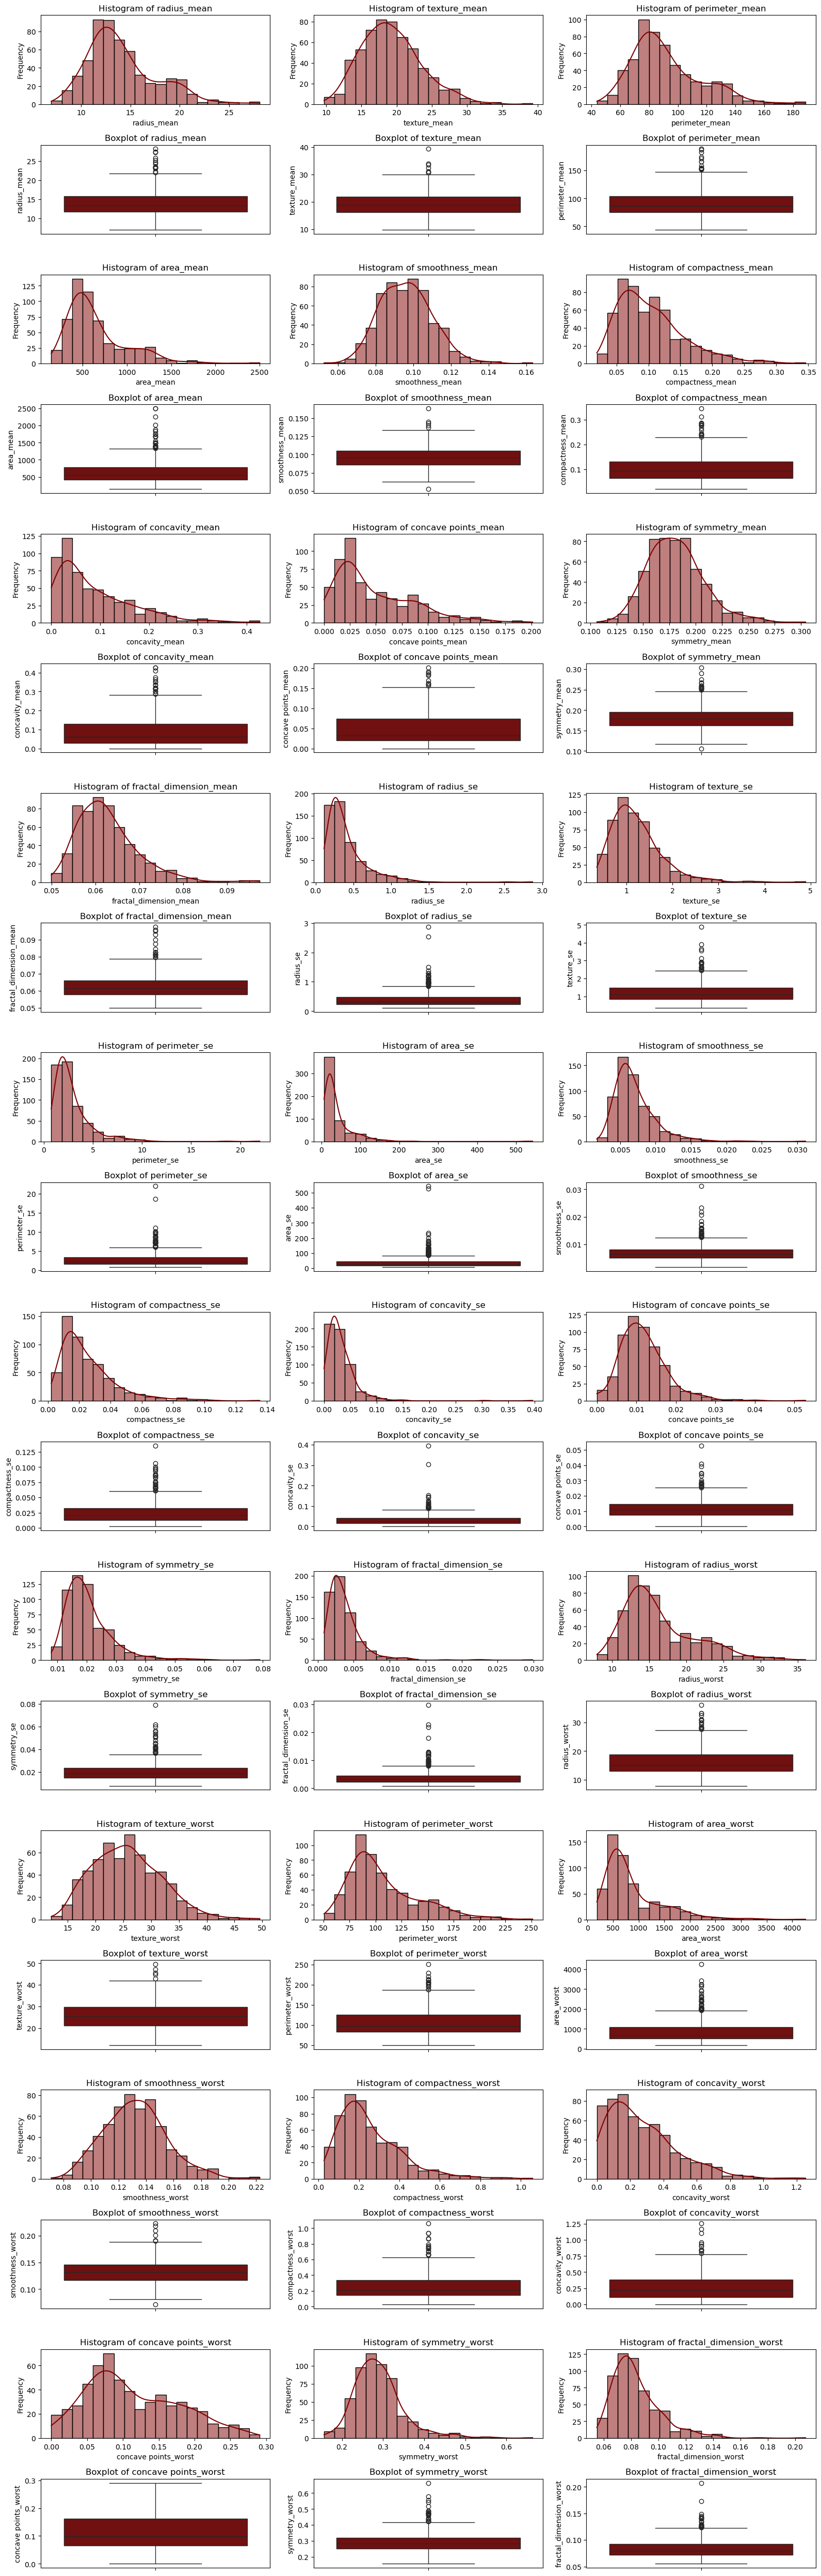

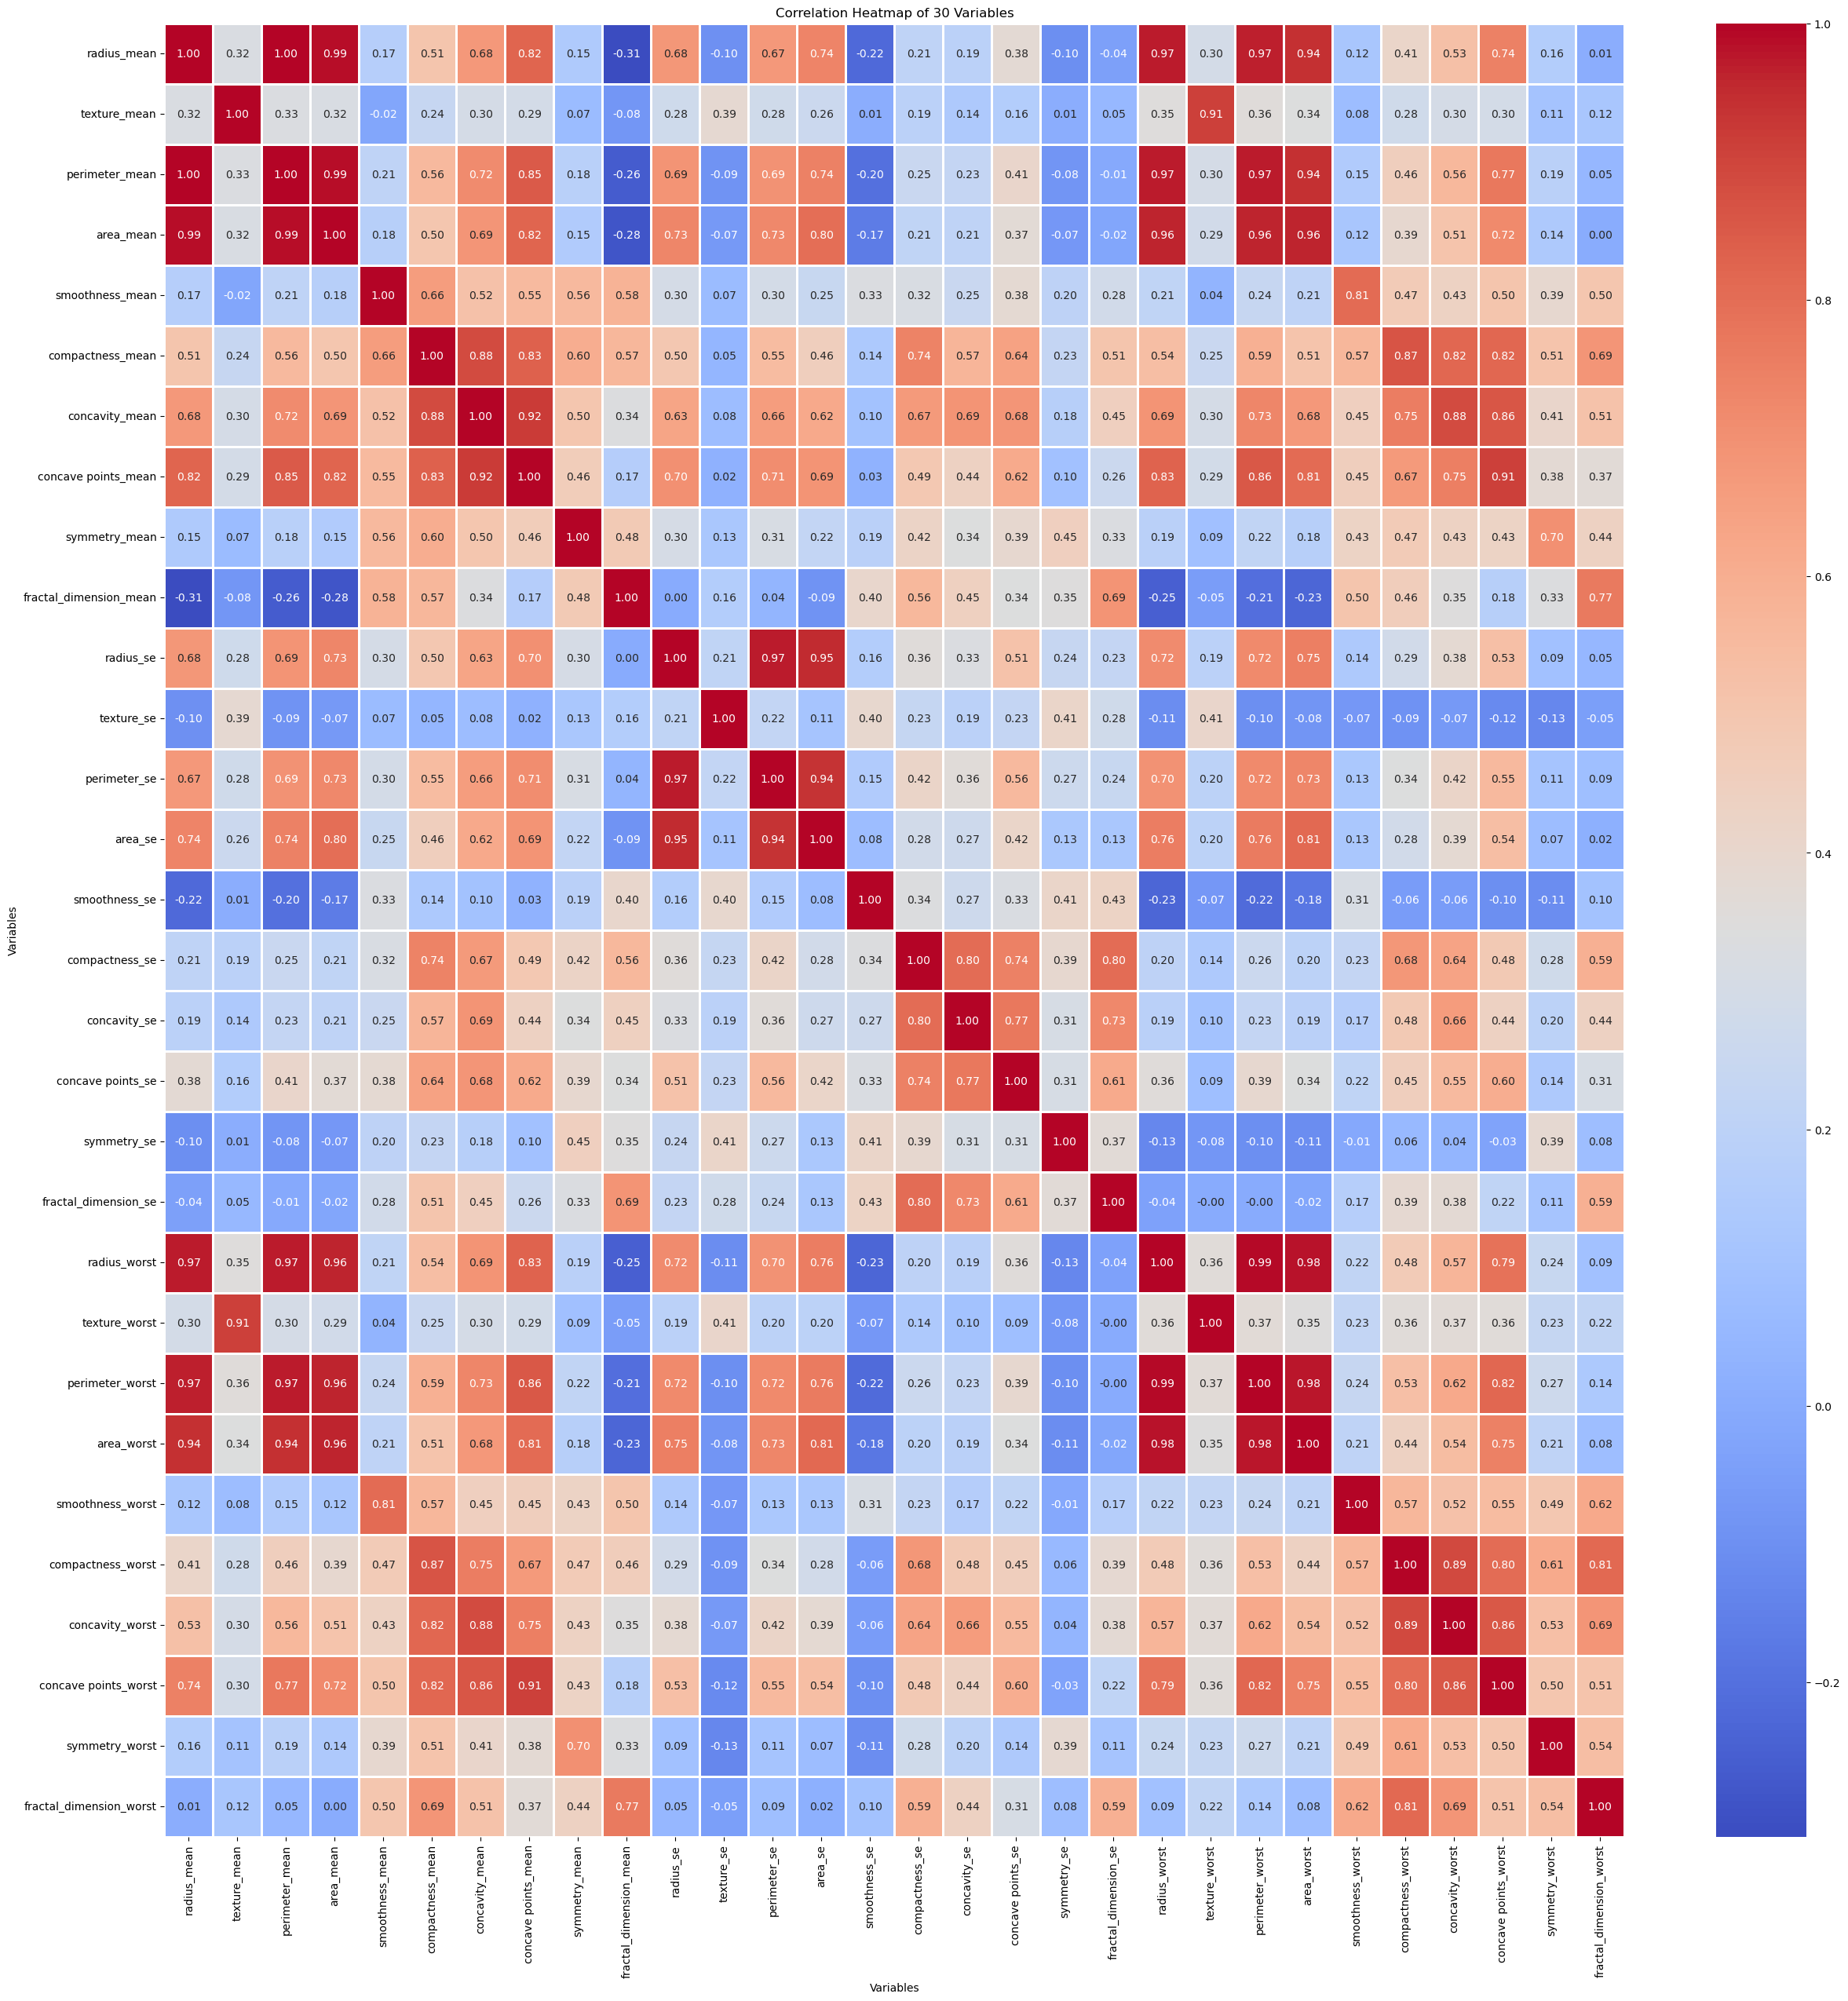

In [ ]:
FtrSlct(data);

In [28]:
import pandas as pd
import numpy as np

def drop_highly_correlated(data, threshold=0.8):
    """
    Drop columns from a DataFrame based on high correlation between columns.

    Parameters:
    - df: DataFrame
    - threshold: Correlation threshold to identify highly correlated columns (default=0.8)

    Returns:
    - DataFrame with highly correlated columns removed
    """
    # Step 1: Calculate the correlation matrix
    corr_matrix = data.corr().abs()

    # Step 2: Identify columns to drop (those with correlations above the threshold)
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Step 3: Find index of columns with correlation greater than the threshold
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    print(f"Columns to drop: {to_drop}")

    # Step 4: Drop the highly correlated columns
    df_reduced = data.drop(columns=to_drop)

    return df_reduced

# Example usage:
correlated_columns = drop_highly_correlated(data, threshold=0.5)


Columns to drop: ['Height', 'MTRANS']


In [29]:
data = data.drop(columns=['Height', 'MTRANS','NObeyesdad'])


In [30]:
data = remove_outliers_iqr(data)


In [31]:
data

,Gender,Age,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC
6,0,23.000000,55.000000,1,1,3.0,3.0,2,0,2.000000,0,1.000000,0.000000,2
22,0,22.000000,60.000000,1,1,3.0,3.0,2,0,2.000000,0,1.000000,0.000000,2
24,1,21.000000,68.000000,1,1,2.0,3.0,2,0,2.000000,0,0.000000,1.000000,2
38,1,23.000000,67.000000,1,1,2.0,3.0,2,0,2.000000,0,1.000000,1.000000,2
39,0,21.000000,88.000000,1,1,2.0,3.0,2,0,3.000000,0,3.000000,0.000000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2106,0,20.976842,131.408528,1,1,3.0,3.0,2,0,1.728139,0,1.676269,0.906247,2
2107,0,21.982942,133.742943,1,1,3.0,3.0,2,0,2.005130,0,1.341390,0.599270,2
2108,0,22.524036,133.689352,1,1,3.0,3.0,2,0,2.054193,0,1.414209,0.646288,2
2109,0,24.361936,133.346641,1,1,3.0,3.0,2,0,2.852339,0,1.139107,0.586035,2


In [32]:
data = normalize_data(data)


New Ranges of the Features:
Gender: Min = 0.0, Max = 1.0
Age: Min = 0.0, Max = 1.0
Weight: Min = 0.0, Max = 0.9999999999999999
family_history_with_overweight: Min = 0.0, Max = 0.0
FAVC: Min = 0.0, Max = 0.0
FCVC: Min = 0.0, Max = 1.0
NCP: Min = 0.0, Max = 1.0
CAEC: Min = 0.0, Max = 0.0
SMOKE: Min = 0.0, Max = 0.0
CH2O: Min = 0.0, Max = 1.0
SCC: Min = 0.0, Max = 0.0
FAF: Min = 0.0, Max = 1.0
TUE: Min = 0.0, Max = 1.0
CALC: Min = 0.0, Max = 0.0


In [33]:
data.shape


(745, 14)

# Finding the best Bandwidth Using Grid Search, Rule of Thumb methods

In [34]:
bandwidth = rule_of_thumb_bandwidth(data, k=12)


Estimated Bandwidth (Rule of Thumb): 0.27069112297759046


GRID SEARCH WITH TSNE

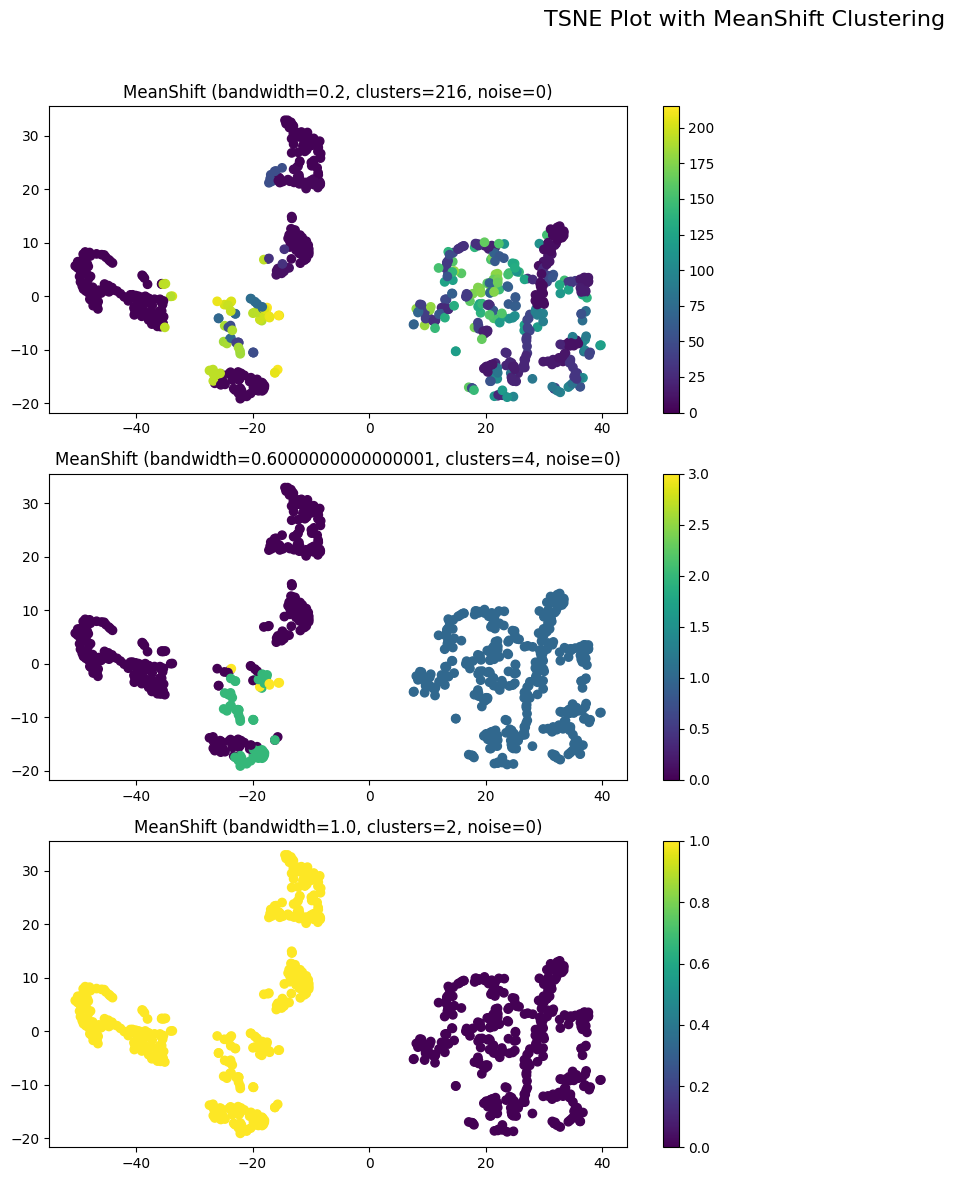

In [36]:
tsne_perform_clustering_and_plot(data)

From above the best bandwidth is 1.0 as it is showing two clusters

# PCA

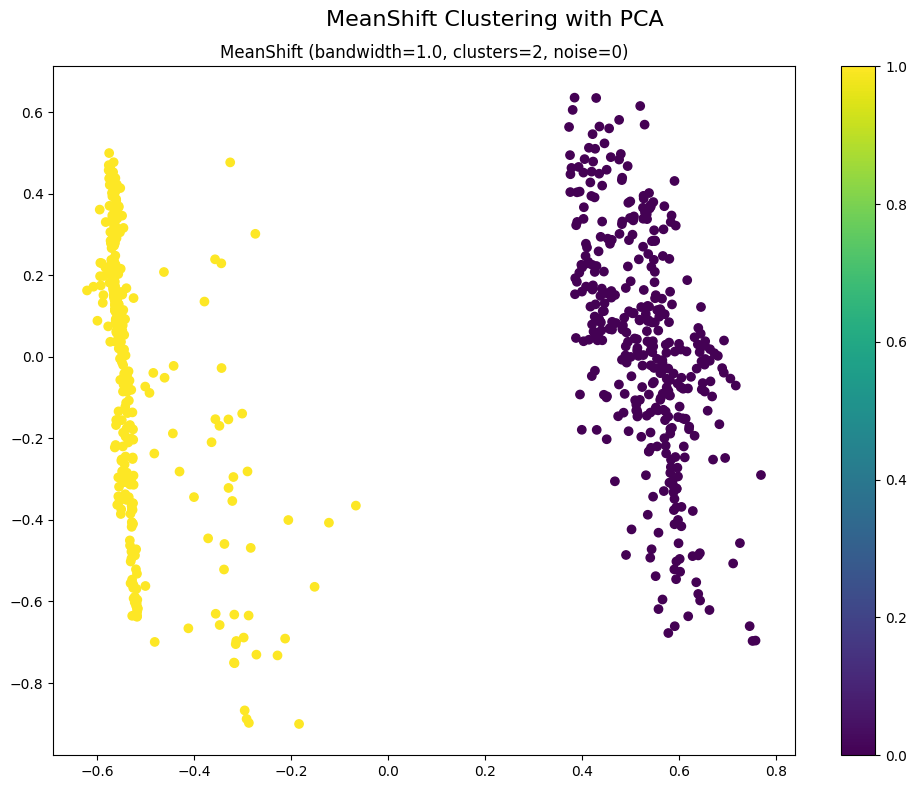

In [37]:
# Specify the MeanShift parameter (bandwidth)
meanshift_params = 1.0  # You can adjust the bandwidth as needed

# Call the function with the generated data and MeanShift parameters
perform_clustering_and_plot(data, meanshift_params)

Two Separate and well identified clusters are created

Using Clusters bandwidth of 1.0

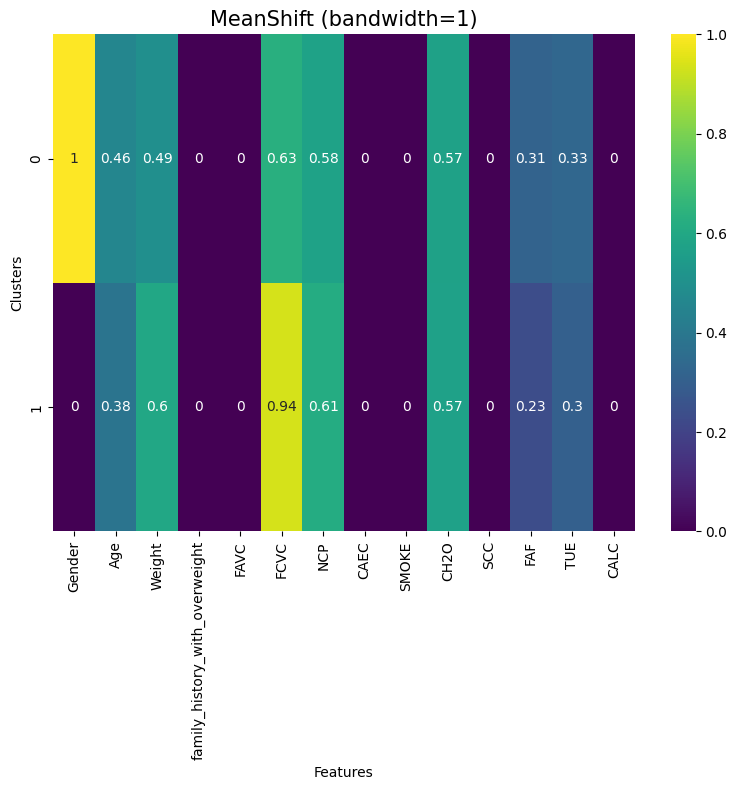

In [38]:
HeatmapFeatureMeansWithClustering(data, bandwidth=1, show_meanshift=True)


The above Visualization shows the two class of the obese and non obese individuals as per the feature FAVC are the indiduals who are consuming healthy diets i.e. vegetables showing healhy weight and BMI

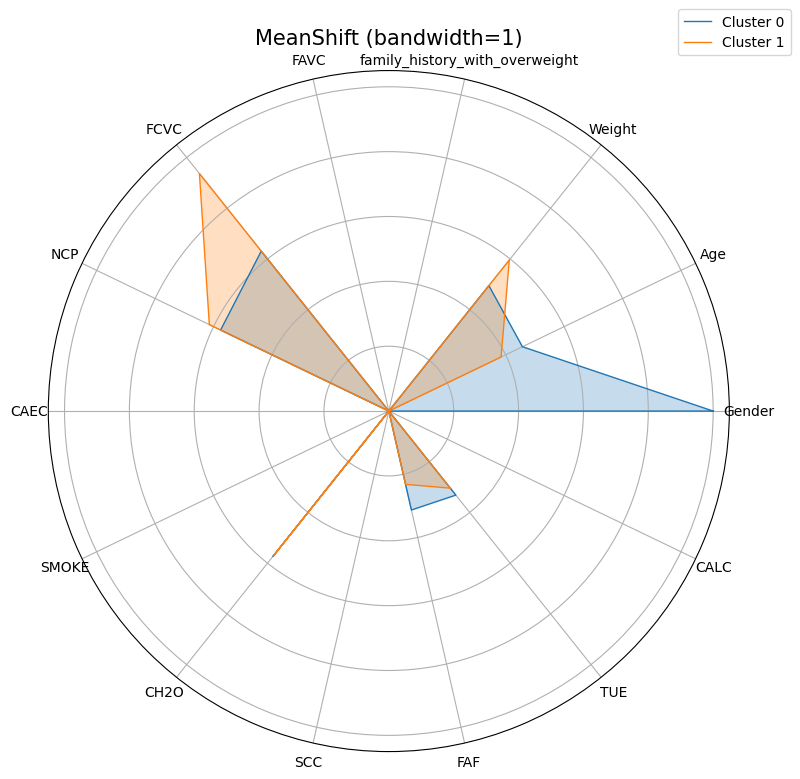

In [39]:
RadialFeatureMeansWithClustering(data, bandwidth=1, show_meanshift=True)


The above Visualization shows the two class of the obese and non obese individuals as per the feature FAVC are the indiduals who are consuming healthy diets i.e. vegetables showing healhy weight and BMI

Now By increasing and decreasig the bandwidth

In [ ]:
Increasing Bandwidth

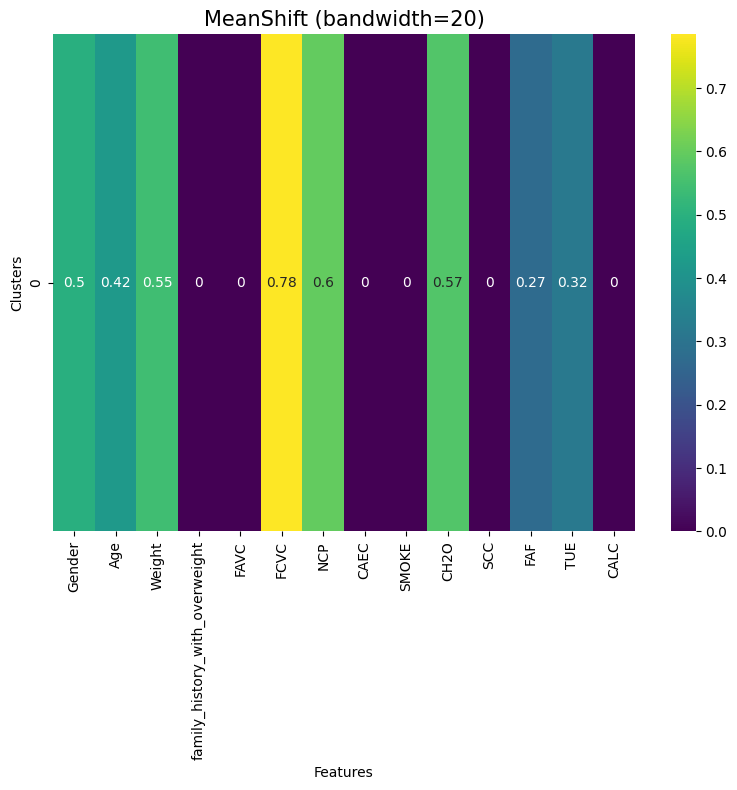

In [41]:
HeatmapFeatureMeansWithClustering(data, bandwidth=20, show_meanshift=True)


No of clusters decreases in Optics

# Decreasing of Bandwidth

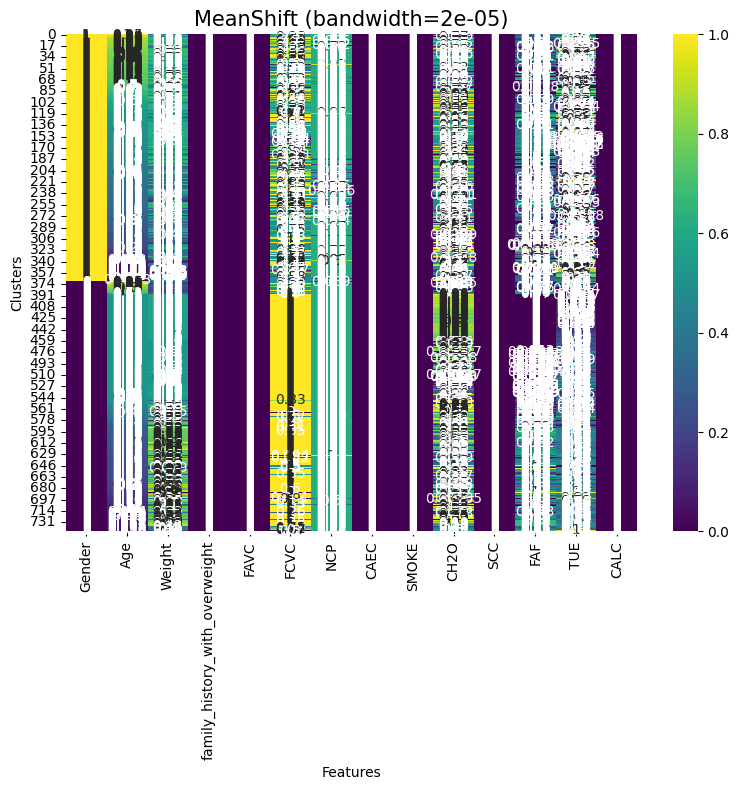

In [42]:
HeatmapFeatureMeansWithClustering(data, bandwidth=0.00002, show_meanshift=True)


No of Clusters increases